In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm
import os

In [2]:
def compute_mutual_info_matrix(data, n_neighbors=3, random_state=42):
    """Compute pairwise mutual information matrix with progress bar"""
    n_features = data.shape[1]
    mi_matrix = np.zeros((n_features, n_features))
    
    for i in tqdm(range(n_features), desc="Computing MI"):
        for j in range(i, n_features):
            # MI is symmetric, so we compute only upper triangle
            mi = mutual_info_regression(
                data[:, i].reshape(-1, 1),
                data[:, j],
                n_neighbors=n_neighbors,
                random_state=random_state
            )[0]
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi  # Symmetric
            
    return mi_matrix

In [3]:
adata = sc.read_h5ad('CPA_latent.h5ad')

In [4]:
# Correlation between factors

In [5]:
disentangled_latent = adata.X

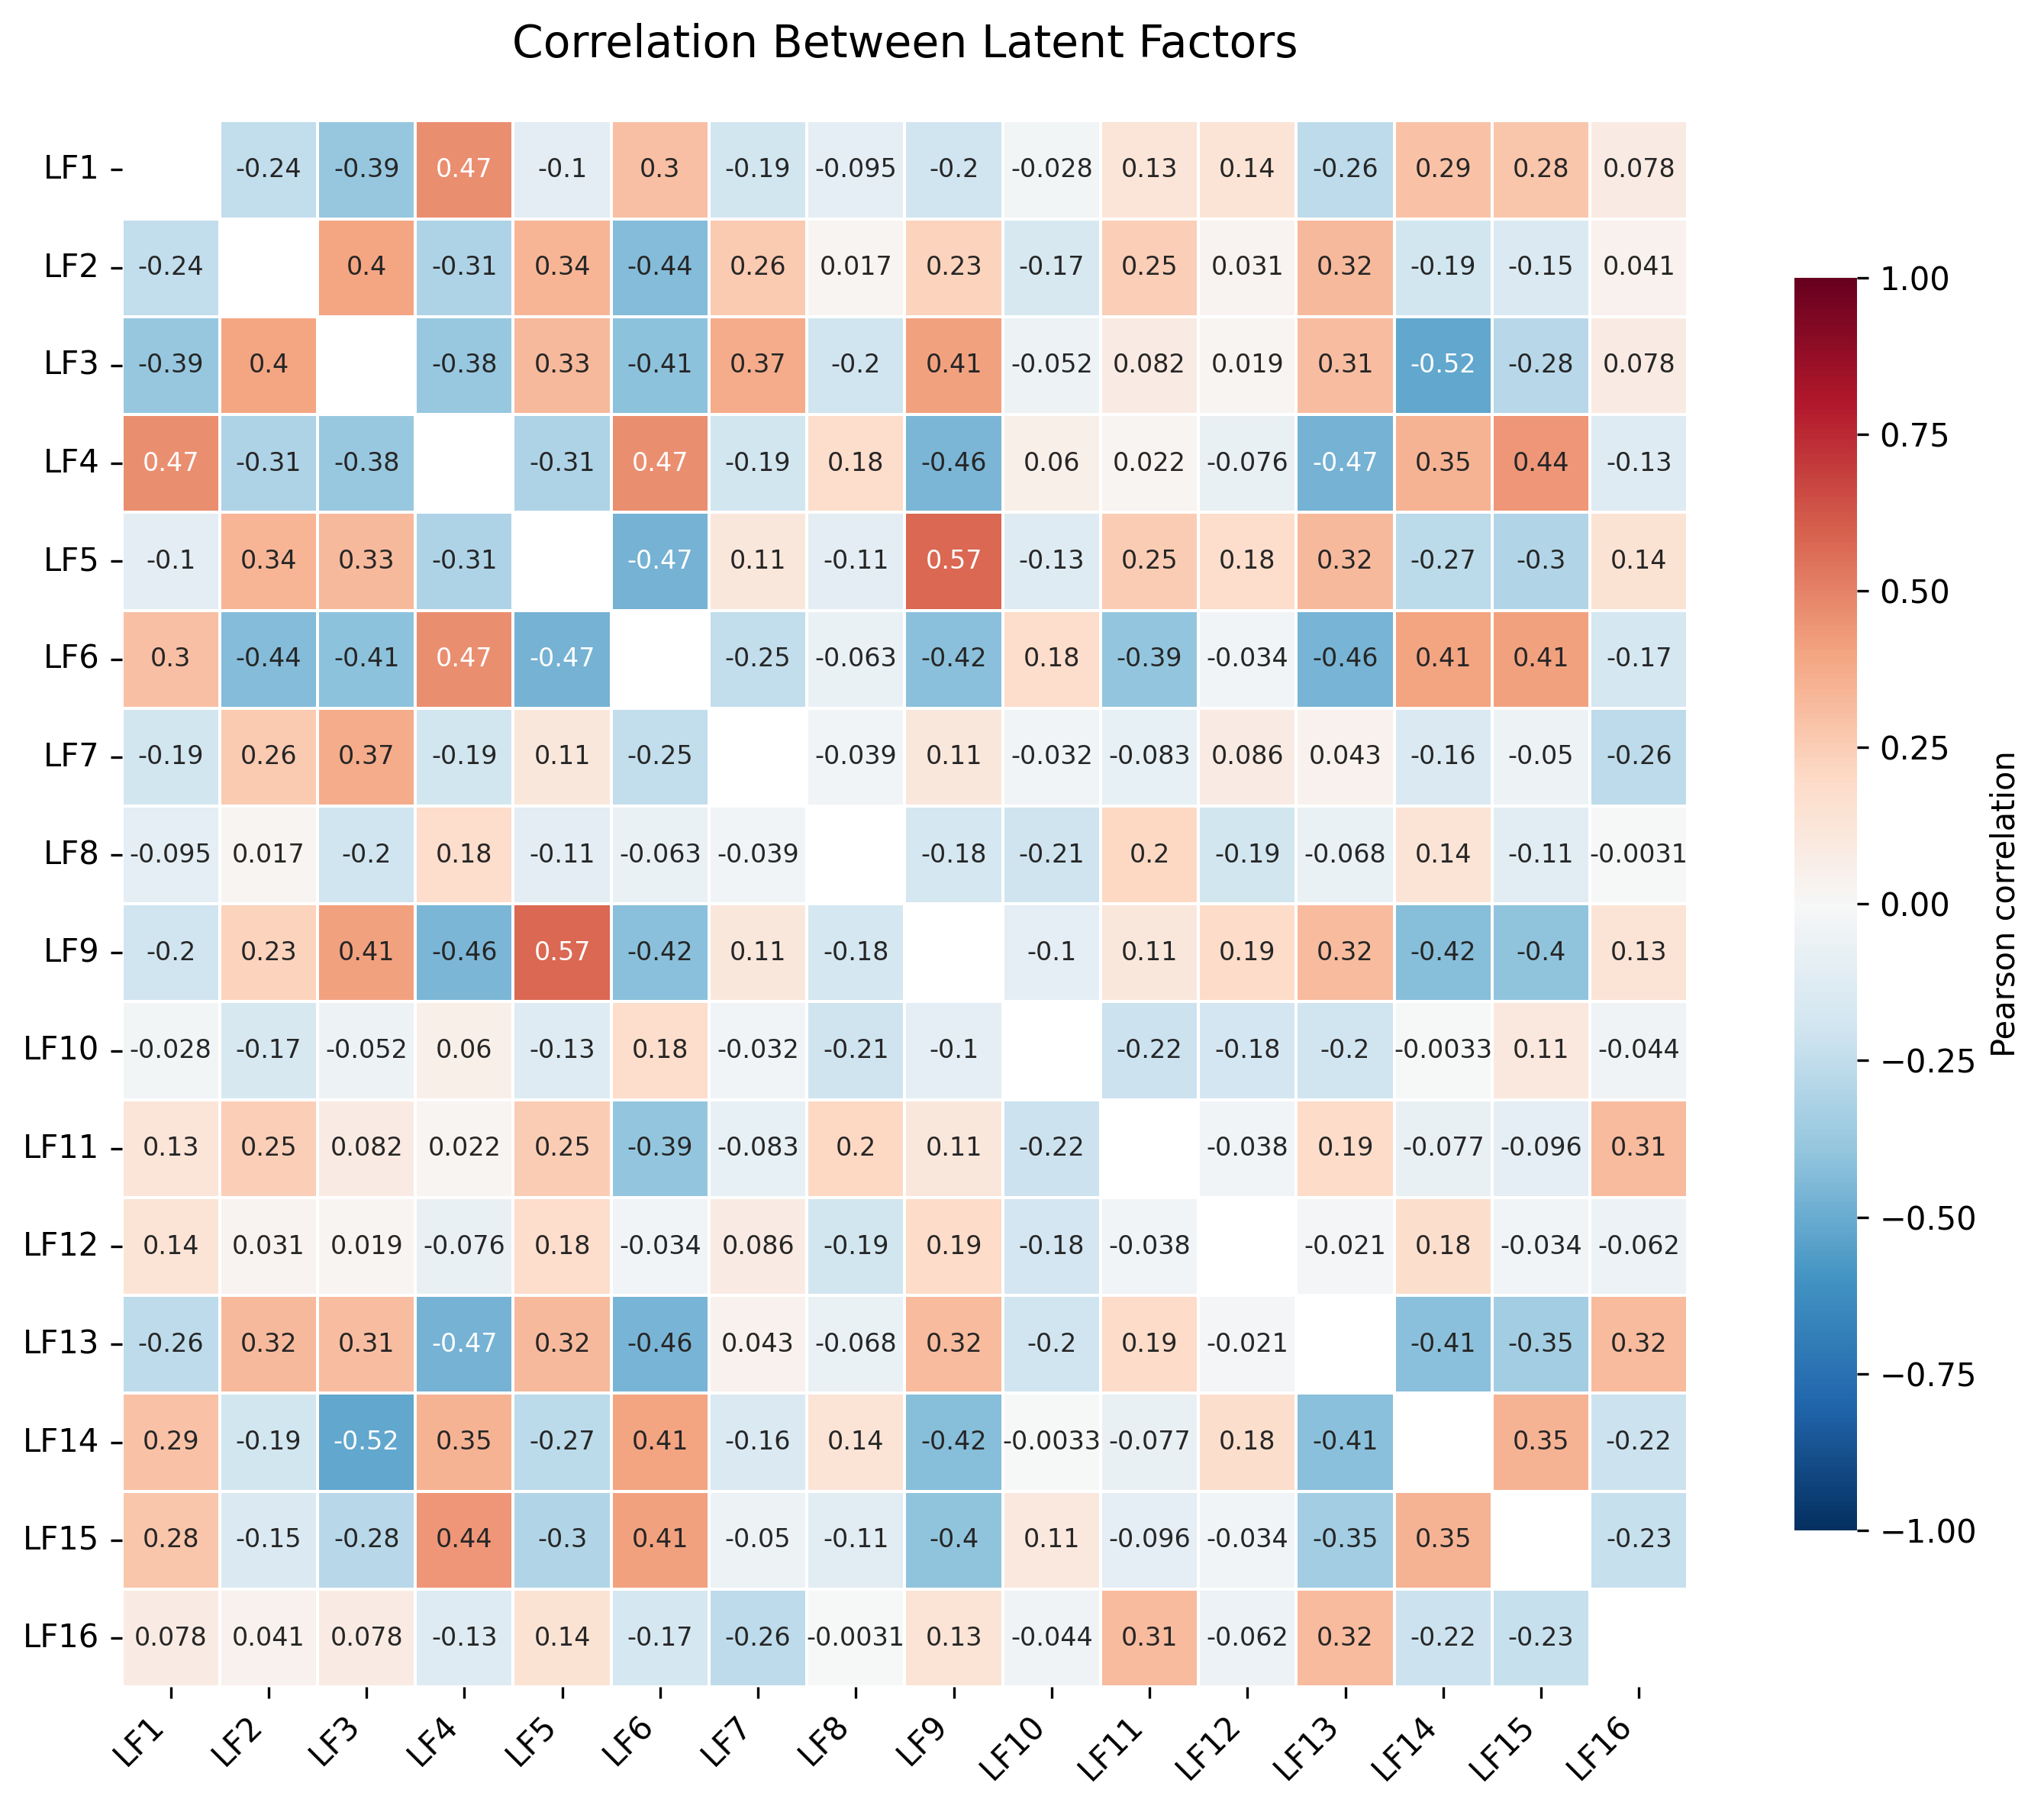

In [6]:
latent_factors = pd.DataFrame(disentangled_latent, columns=[f"LF{i+1}" for i in range(16)])

# Calculate correlation matrix
corr_matrix = latent_factors.corr()
np.fill_diagonal(corr_matrix.values, np.nan)

# Create custom colormap
colors = ["#053061", "#2166ac", "#4393c3", "#92c5de", 
          "#d1e5f0", "#f7f7f7", "#fddbc7", "#f4a582", 
          "#d6604d", "#b2182b", "#67001f"]

cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)

# Create the figure
plt.figure(figsize=(10, 8), dpi=300)

# Create heatmap with seaborn
heatmap = sns.heatmap(
    corr_matrix,
    cmap=cmap,
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    linecolor="white",
    annot=True,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8, "label": "Pearson correlation"}
)

# Customize appearance
heatmap.set_xticklabels(heatmap.get_xticklabels(), 
                       rotation=45, 
                       horizontalalignment='right',
                       fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), 
                       rotation=0, 
                       fontsize=10)

# Add title
plt.title("Correlation Between Latent Factors", 
          pad=20, fontsize=14)

# Adjust layout
plt.tight_layout()

save_path = '/data/scDisentangle figures/Kang/orthogonal_factors/'
os.makedirs(f'{save_path}', exist_ok=True)        
plt.savefig(f'{save_path}corr_CPA.pdf', dpi=400,bbox_inches="tight")
plt.savefig(f'{save_path}corr_CPA.png', dpi=400, bbox_inches="tight")

Computing MI: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.76it/s]


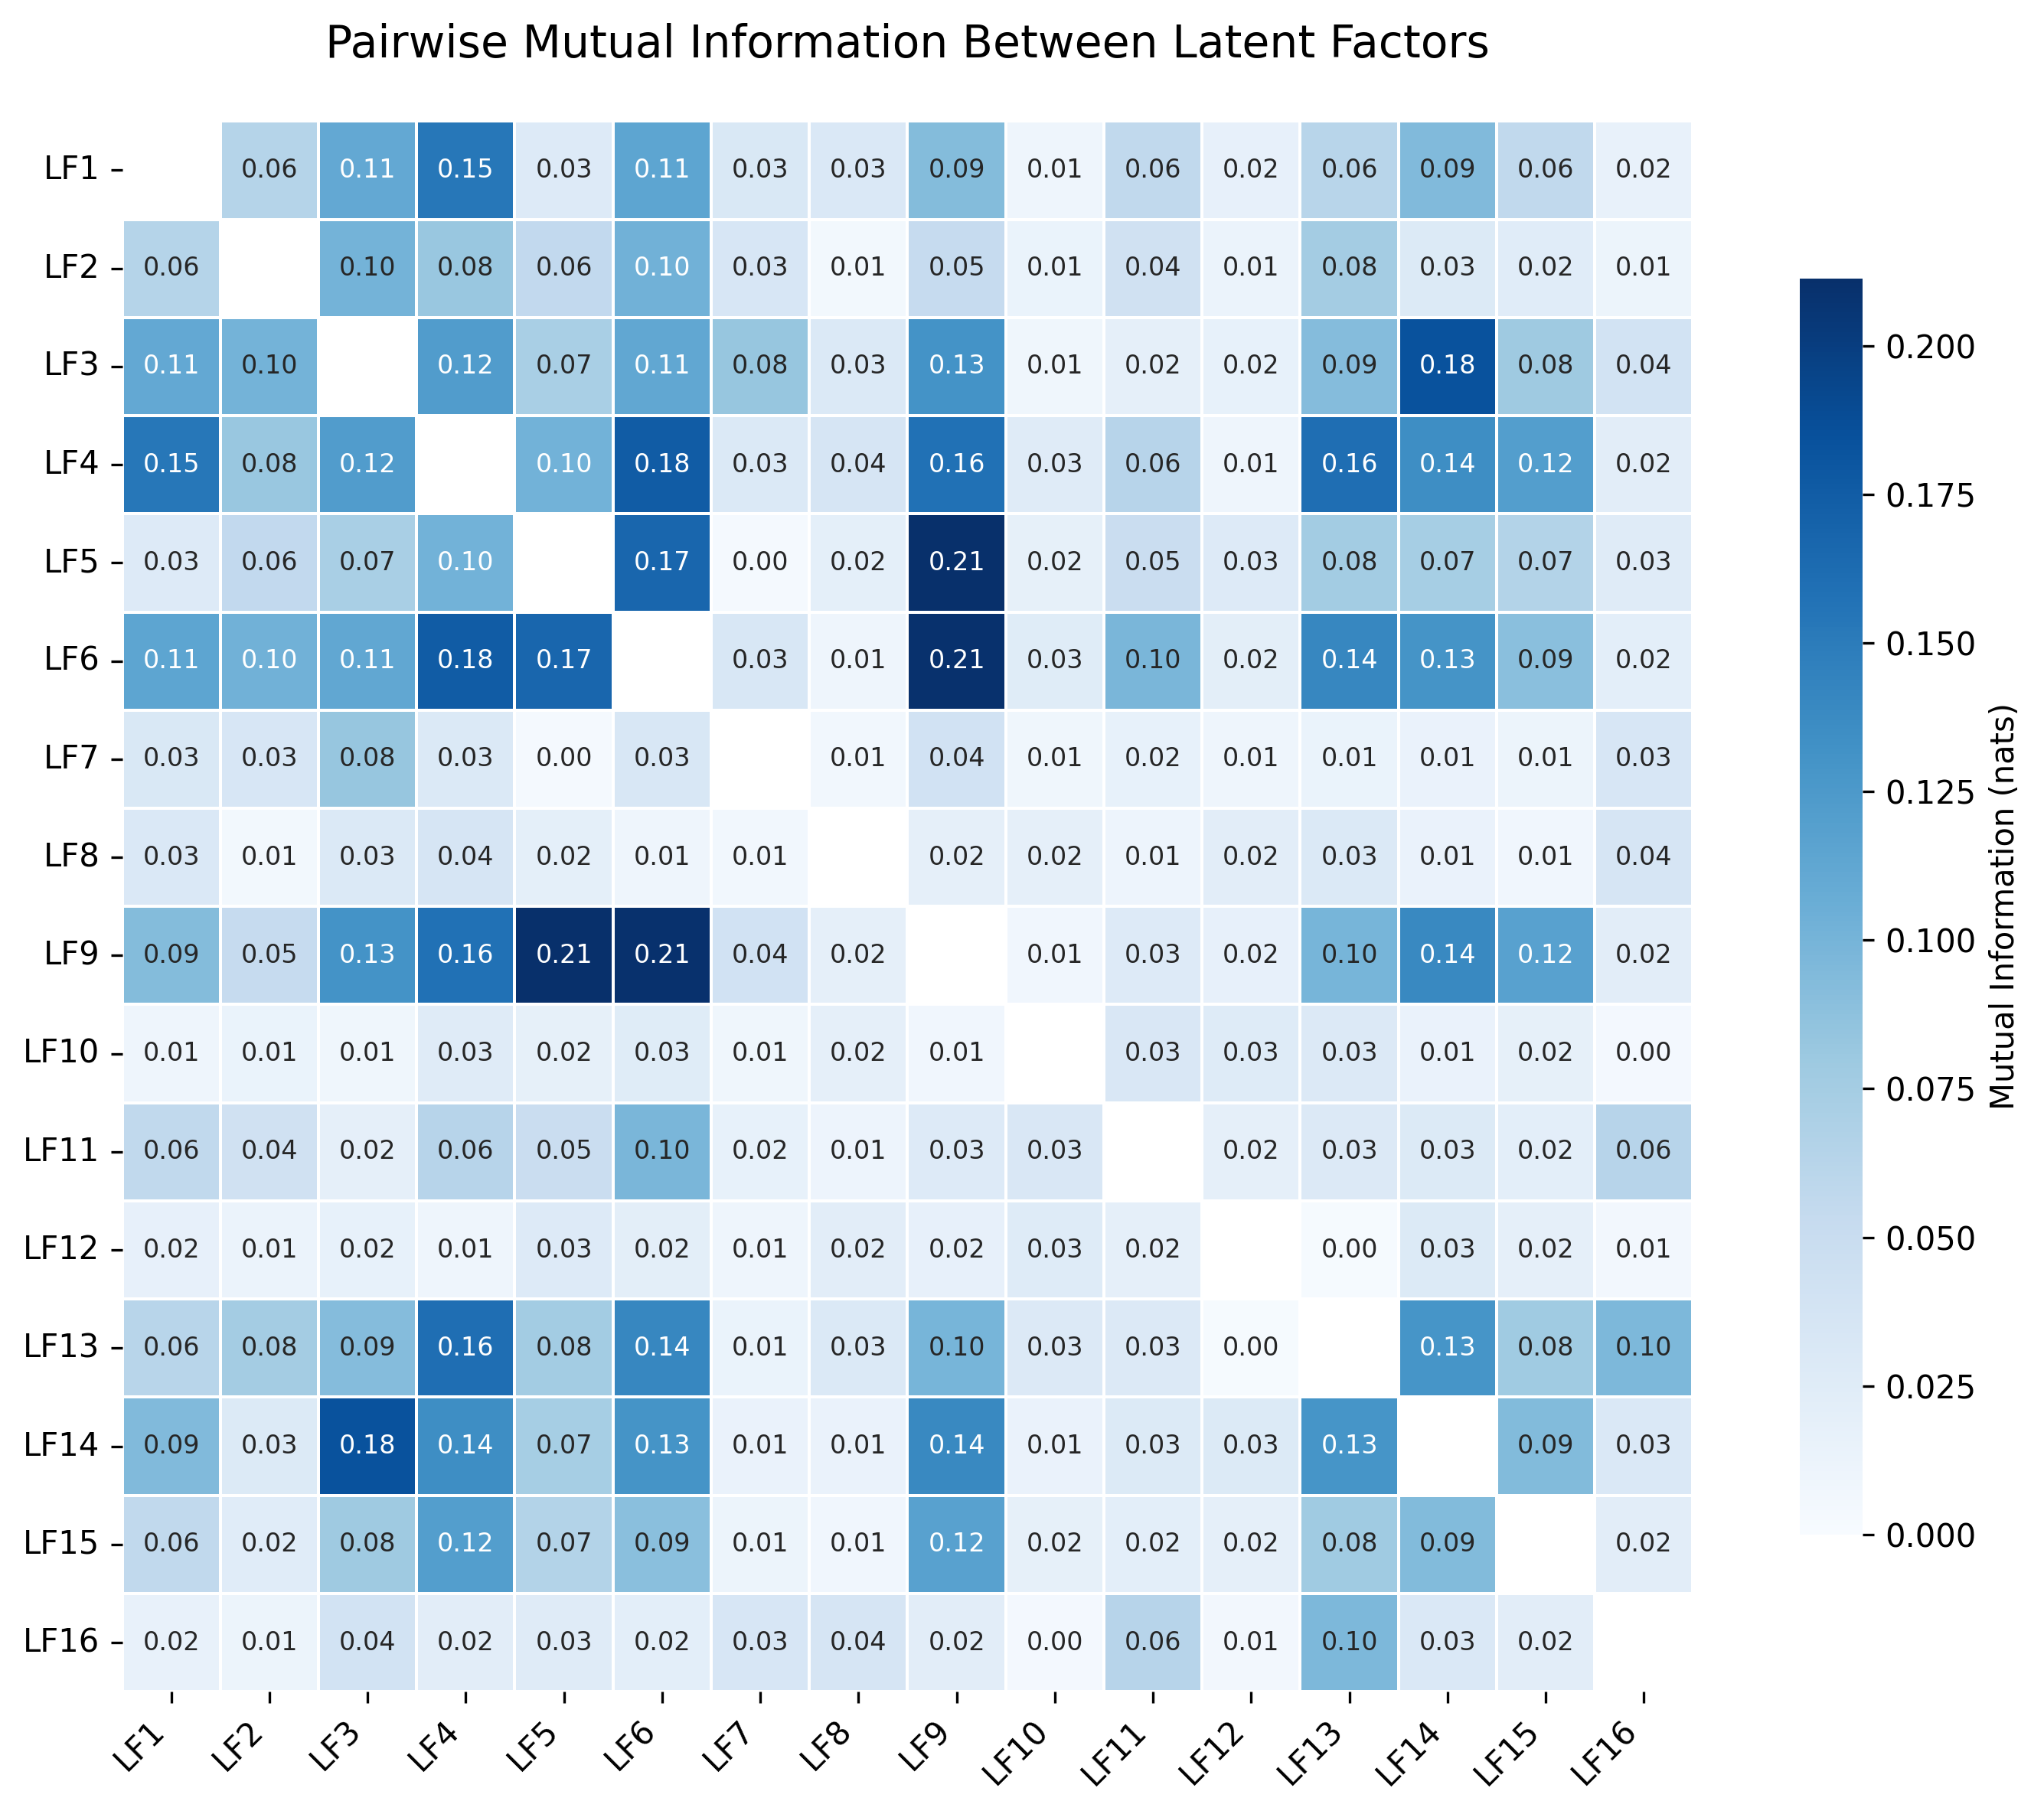

In [7]:
latent_data = disentangled_latent

# Standardize the data
latent_data = (latent_data - latent_data.mean(axis=0)) / latent_data.std(axis=0)

# Compute mutual information matrix
mi_matrix = compute_mutual_info_matrix(latent_data)
np.fill_diagonal(mi_matrix, np.nan)

# Create labels
factor_labels = [f"LF{i+1}" for i in range(latent_data.shape[1])]
mi_df = pd.DataFrame(mi_matrix, index=factor_labels, columns=factor_labels)

# Create custom colormap (sequential since MI is non-negative)
colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", 
          "#6baed6", "#4292c6", "#2171b5", "#08519c", 
          "#08306b"]
cmap = LinearSegmentedColormap.from_list("custom_sequential", colors)

# Create the figure
plt.figure(figsize=(10, 8), dpi=300)

# Create heatmap
heatmap = sns.heatmap(
    mi_df,
    cmap=cmap,
    vmin=0,
    square=True,
    linewidths=0.5,
    linecolor="white",
    annot=True,
    annot_kws={"size": 8},
    fmt=".2f",
    cbar_kws={"shrink": 0.8, "label": "Mutual Information (nats)"}
)

# Customize appearance
heatmap.set_xticklabels(heatmap.get_xticklabels(), 
                       rotation=45, 
                       horizontalalignment='right',
                       fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), 
                       rotation=0, 
                       fontsize=10)

# Add title
plt.title("Pairwise Mutual Information Between Latent Factors", 
          pad=20, fontsize=14)

# Adjust layout
plt.tight_layout()

# Save high-resolution version
save_path = '/data/scDisentangle figures/Kang/orthogonal_factors/'
os.makedirs(f'{save_path}', exist_ok=True)        
plt.savefig(f'{save_path}MI_CPA.pdf', dpi=400,bbox_inches="tight")
plt.savefig(f'{save_path}MI_CPA.png', dpi=400, bbox_inches="tight")

In [8]:
np.fill_diagonal(mi_matrix, 0)
corr_matrix = corr_matrix.to_numpy()
np.fill_diagonal(corr_matrix, 0)

mi_mean = np.mean(np.abs(mi_matrix))
corr_mean = np.mean(np.abs(corr_matrix))

In [9]:
with open('results.txt', 'a') as f:
    f.write(
        f'CPA:\nAverage Correlation: {corr_mean}\nAverage MI: {mi_mean}\n\n'
    )